# How Green Can We Grow?
## Simulating NYC's Journey to 30% Tree Canopy Cover by 2035

By AJ Strauman-Scott

July 15th, 2024

## Introduction
Trees and canopy coverage play a crucial role in cities by providing numerous environmental, social, and economic benefits. They act as natural air purifiers, filtering pollutants and improving air quality. Trees help mitigate urban heat islands by providing shade and reducing surface temperatures. Their presence enhances biodiversity, providing habitats for wildlife and contributing to overall ecological resilience.

In the context of combating climate change, increasing tree canopy coverage is vital. Trees sequester carbon dioxide, a major greenhouse gas, thereby helping to mitigate climate change impacts. They also reduce energy consumption by providing natural cooling and insulation, which can lower the demand for air conditioning and heating in buildings.

Moreover, trees can contribute to economic benefits by increasing property values and attracting businesses, thereby supporting local economies. Socially, green spaces created by trees offer opportunities for community gathering, recreation, and improved mental health outcomes.

The 2017 LiDAR project revealed that more than one-fifth of NYC's land area is covered by tree canopy, comprising 42,654 acres of green, or 22.08% of total land area. Based on these satellite images, the Forest for All NYC coalition released the "NYC Urban Forest Agenda"  in June 2021. Developed collaboratively by almost 50 organizations, the NYC Urban Forest Agenda sets forth 12 priorities, including a goal to achieve 30% canopy cover in New York City by 2035. 

This project models how many saplings New York City needs to plant each year to achieve 30% canopy coverage by 2035.

## Flow Chart

![](canopy_simulation_flowchart.png)


1.  The simulation initializes an environment with the canopy measured by LiDAR in 2017 - 22.08%. 

2.  Since NYC is a city of islands and already close to the land's max capacity, the environment initialized with a `max_trees` attribute to imitate the limits of planting space in the city. 

3.  Once the model determines there are still available planting spots, it plants the number of saplings indicated by the initialized parameters. Each tree planted is assigned one of the five most common species found in the city, and on the NYC Parks Dept approved species list. Each sapling's species is randomly assigned based on the real life distribution of those species. 

4.  Then, all planted trees - from the original canopy and the saplings planted during the model - grow by 1 year. The original canopy grows at the rate observed between 2010 and 2017 LiDAR scans of the city - 1.7%. Each sapling during the simulation run grows at a determined rate based on the real life characteristics of that species.

5.  The model calculates the new area of the tree canopy, and what percent of NYC land it now covers. If it's 30% or greater, the simulation ends.

6.  If the canopy doesn't cover 30%, the model advances by one year, and returns to check planting spots are available. The simulation ends once the year is 2035.

## Custom Classes

In [1]:
# TREE Custom Class
import numpy as np
from scipy.interpolate import interp1d
from pint import UnitRegistry

units = UnitRegistry()

class Tree:
    """
    Represents a tree species with specific growth stages.

    Attributes:
        species (str): The species of the tree.
        growth_stages (list of tuples): List of tuples (age, diameter in feet with units) representing growth stages.
        max_age (int): The age at which the tree stops growing.
        max_diameter (Quantity): The maximum diameter of the tree.
    """

    # Class attribute to store species data
    species_data = {
        "Pin Oak": {
            "growth_stages": [
                (0, 3 * units.feet),
                (12, 25 * units.feet),
                (26, 34 * units.feet),
                (40, 46 * units.feet),
            ],
            "max_age": 54,
            "max_diameter": 60 * units.feet,
        },
        "London Planetree": {
            "growth_stages": [
                (0, 5 * units.feet),
                (12, 40 * units.feet),
                (26, 55 * units.feet),
                (40, 70 * units.feet),
            ],
            "max_age": 200,
            "max_diameter": 80 * units.feet,
        },
        "Honey Locust": {
            "growth_stages": [
                (0, 4 * units.feet),
                (12, 22 * units.feet),
                (26, 28 * units.feet),
                (40, 35 * units.feet),
            ],
            "max_age": 125,
            "max_diameter": 40 * units.feet,
        },
        "Callery Pear": {
            "growth_stages": [
                (0, 2 * units.feet),
                (12, 20 * units.feet),
                (26, 27 * units.feet),
                (40, 30 * units.feet),
            ],
            "max_age": 25,
            "max_diameter": 35 * units.feet,
        },
        "Littleleaf Linden": {
            "growth_stages": [
                (0, 3 * units.feet),
                (12, 27 * units.feet),
                (26, 38 * units.feet),
                (40, 43 * units.feet),
            ],
            "max_age": 200,
            "max_diameter": 50 * units.feet,
        },
    }

    def __init__(self, species):
        """
        Initializes the Tree object.

        Args:
            species (str): The species of the tree.
        """
        self.species = species
        self.growth_stages = Tree.species_data[species]["growth_stages"]
        self.max_age = Tree.species_data[species]["max_age"]
        self.max_diameter = Tree.species_data[species]["max_diameter"]

        # Extract ages and diameters for interpolation
        self.ages, self.diameters = zip(
            *[(age, diameter.magnitude) for age, diameter in self.growth_stages]
        )

        # Cap growth at maximum diameter
        self.ages = self.ages + (self.max_age,)
        self.diameters = self.diameters + (self.max_diameter.magnitude,)

        # Create logarithmic interpolation function
        self.interp_func = interp1d(
            self.ages, np.log(self.diameters), fill_value="extrapolate"
        )

    def canopy_area(self, age):
        """
        Calculates the canopy area of the tree at a given age.

        Args:
            age (int): The age of the tree in years.

        Returns:
            Quantity: The canopy area in square feet.
        """
        diameter = self.get_diameter(age)
        radius = diameter / 2
        area = np.pi * (radius**2)
        return area.to(units.square_feet)  # Convert to square feet

    def get_diameter(self, age):
        """
        Retrieves the diameter of the tree at a given age.

        Args:
            age (int): The age of the tree in years.

        Returns:
            Quantity: The diameter in feet.
        """
        if age >= self.max_age:
            return self.max_diameter
        log_diameter = self.interp_func(age)
        diameter = np.exp(log_diameter) * units.feet
        return diameter

The model creates a custom class `Tree` that initializes an object whose attributes are provided by its randomly assigned species. Each species has its own growth and canopy size characteristics, based on real life growth patterns, written as class attributes and including maximum age (when the tree dies) and maximum canopy diameter. The object attributes are age and canopy diameter, which will be updated throughout the course of the simulation.
All tree objects begin with a canopy diameter that would exist for a sapling with a 3" diameter trunk, to approximate the average 2.5" to 3.5" trunk diameter of the saplings purchased by the Parks Department.

In [2]:
class NoSpaceError(Exception):
    """Custom exception to indicate that there is no more space to plant trees."""
    pass

In [3]:
# CANOPY Custom Class
import random

# Set seed for reproducibility
random.seed(713)

class Canopy:
    """
    Represents the growing NYC canopy

    Attributes:
        initial_canopy (Quantity): The initial canopy area in acres.
        nyc (Quantity): The total land area in NYC in acres.
        canopy_that_changes (Quantity): The base canopy area that changes over time in acres.
        base_growth (float): The annual base growth rate.
        t_0 (Quantity): The starting year of the simulation.
        t_end (Quantity): The ending year of the simulation.
    """

    initial_canopy = 42654 * units.acre  # 2017 canopy acreage
    nyc = 193414 * units.acre  # Total land area in NYC
    base_growth = 0.010894975517285266  # Annual base growth rate

    species_distribution = {  # Probabilities based on real life frequencies
        "London Planetree": 0.29,
        "Honey Locust": 0.21,
        "Callery Pear": 0.20,
        "Pin Oak": 0.18,
        "Littleleaf Linden": 0.12,
    }

    def __init__(self, env, max_trees):
        """
        Initializes the Tree object.

        Args:
            env (simpy.Environment): The simulation environment.
            max_trees (int): Maximum number of trees that can be planted.
        """
        self.env = env
        self.trees = []
        self.max_trees = max_trees
        self.species_list = list(Canopy.species_distribution.keys())
        self.species_probabilities = list(self.species_distribution.values())
        self.base_canopy = Canopy.initial_canopy
        self.canopy_that_changes = 9749 * units.acre
        self.total_canopy = Canopy.initial_canopy
        self.percent_canopy = self.total_canopy / Canopy.nyc * 100

    def select_tree_species(self):
        """
        Selects a tree species based on predefined probabilities.

        Returns:
             str: The selected tree species.
        """
        return random.choices(self.species_list, self.species_probabilities, k=1)[0]

    def plant_trees(self, count=1):
        """
        Plants a specified number of trees.

        Args:
            count (int): Number of trees to be planted. Default is 1.
        """
        for _ in range(count):
            if len(self.trees) < self.max_trees:
                species = self.select_tree_species()
                tree = Tree(species)
                self.trees.append({"tree": tree, "age": 0, "planted": self.env.now})
            else:
                raise NoSpaceError("There are no more spaces to plant trees!")

    def grow_trees(self):
        """
        Increments the age of all trees in the forest by 1 year.
        """
        for tree_data in self.trees:
            tree_data["age"] += 1

    def base_canopy_growth(self):
        """
        Updates the percentage of total land in NYC that is covered by the canopy.

        Returns:
            Quantity: The total  base growth canopy area.
        """
        changing_canopy = self.canopy_that_changes  # acres that grow

        new_acres = changing_canopy * Canopy.base_growth  # New acres of growth
        self.canopy_that_changes += new_acres  # Increase the canopy that can grow
        self.base_canopy += new_acres  # Increase the total acres of canopy

        return self.base_canopy

    def calculate_canopy_percent(self):
        """
        Updates the percentage of total land in NYC that is covered by the canopy.

        Returns:
            Quantity: The percentage of NYC land covered by the canopy.
        """
        base_canopy = self.base_canopy_growth()
        planted_canopy = sum(
            tree_data["tree"].canopy_area(tree_data["age"]) for tree_data in self.trees
        ).to(units.acres)
        self.total_canopy = planted_canopy + base_canopy
        self.percent_canopy = self.total_canopy / Canopy.nyc * 100
        return self.percent_canopy

The model also creates a custom parent class of `Tree`, called `Canopy`. The class only initializes one object in the environment - a single canopy containing the original canopy and its growth, plus the forest of planted `Tree` objects and their growth.

The class attributes include the arceage of the 2017 canopy, the total NYC land arceage, and the growth rate of that base canopy. The base canopy growth rate was calculated using the study findings. New York City lost 6,477 acres of tree canopy citywide between 2010 and 2017. Canopy cover loss can occur incrementally as tree health declines over time or it can happen very abruptly as a result of severe weather events such as high winds, snow, or ice. In 2012 'Superstorm' Sandy did both. One of the most destructive weather events in New York City's recent history, the storm felled thousands of trees immediately and then killed thousands more gradually due to the negative effects of saltwater inundation.  The reat of loss between 2010 and 2017 was 3.3% overall, achieving a net growth of 1.7%.

This sort of storm is a rare and unpredictable event. Individual tree loss is not rare, but is unpredictable with sparse research on urban tree loss rates. This simple model does not factor tree loss into the growth of the planted sapling canopy. All tree loss is considered and calculated into the growth rate of the base canopy. Since the growth of the base canopy includes significant losses to unusual hurricane Sandy, including tree loss only in the base canopy should still accurately reflect real world loss rates overall.

## Initial Environment

In [4]:
# RUN SIMULATION
import simpy

def run_simulation(planting_schedule, max_trees):
    """
    Runs the simulation with a specified planting schedule.
    """
    env = simpy.Environment()
    canopy = Canopy(env, max_trees=max_trees)
    years = 19  # From 2017 to 2035

    results = {}

    for year in range(years):
        current_year = 2017 + year

        if current_year in planting_schedule:
            canopy.plant_trees(planting_schedule[current_year])

        canopy.grow_trees()

        canopy_percentage = canopy.calculate_canopy_percent()
        results[current_year] = canopy_percentage

        env.run(until=env.now + 1)

    return results

The function initializes a new `Simpy` environment, a new `Canopy` object, and a `results` dictionary that will store the year and the percent canopy coverage achieved that year. The for loop then calls custom class methods to progress through the flow chart steps until the simulation runs out of planting spaces, time or achieves 30% canopy coverage.


## Data and Methods 
The model runs for 19 interations, to span (and include) all the years from 2017 to 2035, to simulate and track the growth from the known 22% canopy coverage value.
This project was modeled in the year 2024, so the model's planting schedule is fixed from 2017 through 2024, reflecting the actual trees that were planted during those years. For years 2025 and beyond, the model swept parameters to determine how many trees must be planted between July 2024 and July 2035 (the trees are totalled at the end of the fiscal year) to reach a 30% canopy by 2035.

## Validity and Verification
The validity of the model is justified by its grounding in empirical data and established growth patterns of urban trees. The initialization parameters, such as the starting canopy coverage based on the 2017 LiDAR project and specific growth rates derived from studies, ensure that the model accurately reflects the current state and potential growth of NYC's urban forest. The model uses realistic species distribution and growth rates, which enhances its applicability and reliability in simulating canopy growth.

The model was verified using two approaches:

1.  Historical Data Comparison: The model's outputs were compared against historical data to ensure consistency with observed trends. By simulating past years using actual planting data and comparing the results to known canopy coverage, we could assess the model's accuracy.
    
2.  Sensitivity Analysis: This analysis adjust parameters such as the growth rates, planting rates, and species distribution to analyze the sensitivity of the model, as well as identify critical parameters that have significant impacts on the model's output to understand the robustness of the model.## Verify Model

In [7]:
def sensitivity_analysis():
    """
    Perform sensitivity analysis on a tree canopy simulation model with different growth rates.
    
    This function initializes a planting schedule and tests the simulation model with various growth rates.
    It calculates the tree canopy percentage for the year 2035 based on the adjusted parameters.

    Returns:
    None. Prints out sensitivity analysis results showing how different growth rates affect canopy coverage.
    """
    planting_schedule = {
        2017: 10000,
        2018: 12000,
        2019: 12000,
        2020: 7300,
        2021: 13000,
        2023: 14900,
        2024: 18000,
    }
    max_trees_sensitivity = 500000  
    growth_rates = [0.015, 0.017, 0.020]  # Different growth rates for sensitivity analysis

    sensitivity_results = {}
    for growth_rate in growth_rates:
        canopy = Canopy(simpy.Environment(), max_trees=max_trees_sensitivity)
        canopy.base_growth = growth_rate  # Adjusting growth rate
        result = run_simulation(planting_schedule, max_trees_sensitivity)
        sensitivity_results[growth_rate] = result[2035]

    print("\nSensitivity Analysis Results:")
    for growth_rate, canopy_percentage in sensitivity_results.items():
        print(f"With growth rate {growth_rate}, canopy percentage in 2035 is {canopy_percentage:.2f}%")


In [8]:
sensitivity_analysis()

Growth rate: 0.015, Canopy Percentage in 2035: 24.02 dimensionless%
Growth rate: 0.017, Canopy Percentage in 2035: 24.02 dimensionless%
Growth rate: 0.02, Canopy Percentage in 2035: 24.02 dimensionless%

Sensitivity Analysis Results:
With growth rate 0.015, canopy percentage in 2035 is 24.02 dimensionless%
With growth rate 0.017, canopy percentage in 2035 is 24.02 dimensionless%
With growth rate 0.02, canopy percentage in 2035 is 24.02 dimensionless%


All three growth rates return 24.02% canopy by 2035. Because individual trees are measured in feet and are planted as 3" diameter trunk saplings, and canopy coverage is measured in arces, this model is highly insensitive. Extremely large numbers of trees are required to influence the model.

## Parameter Sweep

When run with one billion possible planting spaces, a parameter sweep returns a value of **318,812** as the minimum number of trees NYC must plant each year from 2025 to 2035 to achieve its goal of 30% canopy coverage by the given deadline.

In [9]:
import matplotlib.pyplot as plt

def how_many_trees(planting_schedule, max_trees, target_percent, years_to_modify, max_planted=150000):
    """
    Finds the number of trees that need to be planted each year to reach the target canopy percentage.

    Args:
        planting_schedule (dict): The initial planting schedule.
        max_trees (int): The maximum number of trees that can be planted.
        target_percent (float): The target canopy percentage to achieve by 2035.
        years_to_modify (list): The years to apply the same planting count.
        initial_guess (int): The initial guess for the number of trees to plant.

    Returns:
        int: The number of trees to plant each year to achieve the target canopy percentage.
    """
    low, high = 0, max_planted
    best_count = 0
    tolerance = 0.05  # Tolerance for the target canopy percentage

    tree_counts = []
    canopy_percentages = []

    while low <= high:
        mid = (low + high) // 2
        for year in years_to_modify:
            planting_schedule[year] = mid

        results = run_simulation(planting_schedule, max_trees)
        canopy_percentage = results[2035]

        tree_counts.append(mid)
        canopy_percentages.append(canopy_percentage)

        print(f"Trying {mid} trees/year: {canopy_percentage:.2f}% canopy in 2035")

        if abs(canopy_percentage - target_percent) < tolerance:
            best_count = mid
            break
        elif canopy_percentage < target_percent:
            low = mid + 1000
        else:
            high = mid - 1000

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(tree_counts, canopy_percentages, marker='o')
    plt.axhline(y=target_percent, color='r', linestyle='--', label=f'Target: {target_percent}%')
    plt.xlabel('Trees Planted Each Year')
    plt.ylabel('Canopy Percentage in 2035')
    plt.title('Trees Planted vs. Canopy Percentage in 2035')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_count

In [10]:
# Establish initial parameters
planting_schedule = {
    2017: 10000,
    2018: 12000,
    2019: 12000,
    2020: 7300,
    2021: 13000,
    2023: 14900,
    2024: 18000, # Numbers of actual trees planted these years.
    2025: 25000,
    2026: 25000,
    2027: 25000,
    2028: 25000,
    2029: 25000,
    2030: 25000,
    2031: 25000,
    2032: 25000,
    2033: 25000,
    2034: 25000,
    2035: 25000
}

max_trees = 1000000000 # One billion
target_percent = 30.0
years_to_modify = list(range(2025, 2036))
max_planted = 600000 # Number chosen based on previous simulation runs

Trying 300000 trees/year: 29.65 dimensionless% canopy in 2035
Trying 450500 trees/year: 32.48 dimensionless% canopy in 2035
Trying 375250 trees/year: 31.07 dimensionless% canopy in 2035
Trying 337625 trees/year: 30.36 dimensionless% canopy in 2035
Trying 318812 trees/year: 30.01 dimensionless% canopy in 2035


/Users/seshat/Documents/MSDS/2024-summer/DATA604/604_venv/lib/python3.12/site-packages/numpy/core/shape_base.py:65: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  ary = asanyarray(ary)


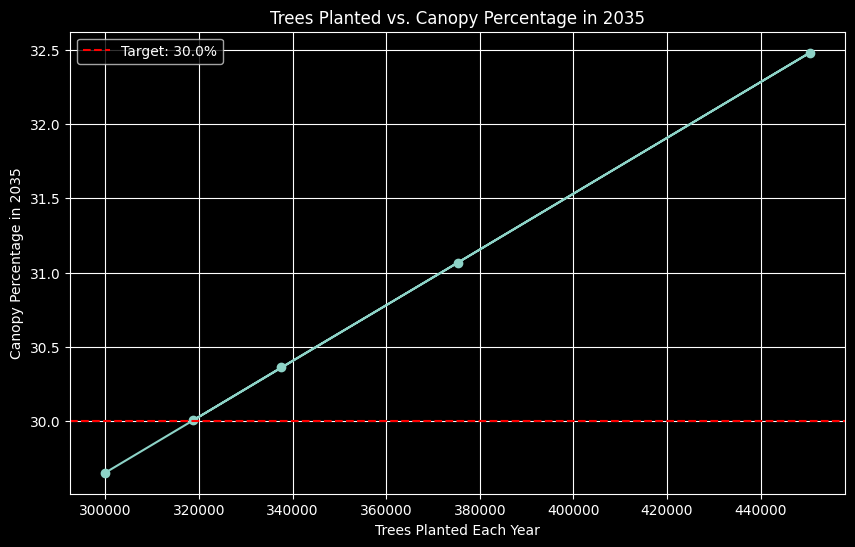

Trees needed per year from 2025 to 2035 to reach 30.0% canopy: 318812


In [11]:
# Run the Sweep
trees_needed = how_many_trees(planting_schedule, max_trees, target_percent, years_to_modify, max_planted)
print(f"Trees needed per year from 2025 to 2035 to reach {target_percent}% canopy: {trees_needed}")

The parameter sweep reveals the NYC Urban Forest Agenda's 30% coverage goal is practically impossible. As of July 2nd, 2024, New York City Dept of Recreation identified 113,060 possible planting spaces across the five bouroughs , although the report from believes there may be an opportunity to plant approximately 250,000 additional street trees as well as more in parks and private land. However, these numbers are nowhere near the required 3.18 million spaces that are needed to achieve the desired 30% canopy coverage by the 2035 deadline.

This issue stems primarily from the size of the saplings at the time of planting. These saplings begin with a very small canopy size, and take decades to reach full height and thus full canopy. The city could counteract this issue by purchasing larger saplings to plant. However, larger plants will greatly increase the cost of the project to the city.

## Updated Model

In [13]:
def years_to_goal(max_trees):
    """
    Runs the simulation with a specified planting schedule and calculates how long it will take to reach 30% canopy cover.

    Args:
        max_trees (int): The maximum number of trees that can be planted.

    Returns:
        int: The year when the canopy reaches 30%.
    """
    env = simpy.Environment()
    canopy = Canopy(env, max_trees=max_trees)
    years = 19  # From 2017 to 2035

    results = {}
    trees_planted_per_year = {}

    planting_schedule = {
        2017: 10000,
        2018: 12000,
        2019: 12000,
        2020: 7300,
        2021: 13000,
        2023: 14900,
        2024: 18000,
    }

    # Calculate the number of trees to plant each year from 2025 to 2035
    remaining_years = 2035 - 2024
    total_trees_planted = sum(planting_schedule.values())
    available_spaces = max_trees - total_trees_planted
    trees_per_year = available_spaces // remaining_years

    for year in range(years):
        current_year = 2017 + year

        if current_year in planting_schedule:
            trees_to_plant = planting_schedule[current_year]
        elif current_year > 2024:
            trees_to_plant = min(trees_per_year, available_spaces)

        if trees_to_plant > 0:
            try:
                canopy.plant_trees(trees_to_plant)
                available_spaces -= trees_to_plant
                trees_planted_per_year[current_year] = trees_to_plant
            except NoSpaceError:
                print("No more spaces available for planting trees.")
                break

        canopy.grow_trees()

        canopy_percentage = canopy.calculate_canopy_percent()
        results[current_year] = canopy_percentage

        env.run(until=env.now + 1)

        if canopy_percentage >= 30:
            final_year = current_year
            break
    else:
        # Continue the simulation after 2035 if needed
        final_year = 2035
        while results[final_year] < 30:
            final_year += 1
            trees_to_plant = min(trees_per_year, available_spaces)
            if trees_to_plant > 0:
                try:
                    canopy.plant_trees(trees_to_plant)
                    available_spaces -= trees_to_plant
                    trees_planted_per_year[final_year] = trees_to_plant
                except NoSpaceError:
                    print("No more spaces available for planting trees.")
                    break
            
            canopy.grow_trees()
            canopy_percentage = canopy.calculate_canopy_percent()
            results[final_year] = canopy_percentage
            env.run(until=env.now + 1)

    # Plot the results
    years = list(results.keys())
    canopy_percentages = list(results.values())
    trees_planted = [trees_planted_per_year.get(year, 0) for year in years]

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Trees Planted', color='tab:green')
    ax1.bar(years, trees_planted, color='tab:green', alpha=0.5)
    ax1.tick_params(axis='y', labelcolor='tab:green')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Percent Canopy Coverage', color='tab:blue')
    ax2.plot(years, canopy_percentages, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title(f'Canopy Coverage for {max_trees} Planting Spaces')
    plt.show()

    return final_year

After examining these findings, another model was developed to examine how long achieving 30% canopy coverage will take if all available planting spaces are used by 2035. The model was run twice, once with each estimate of available planting locations.

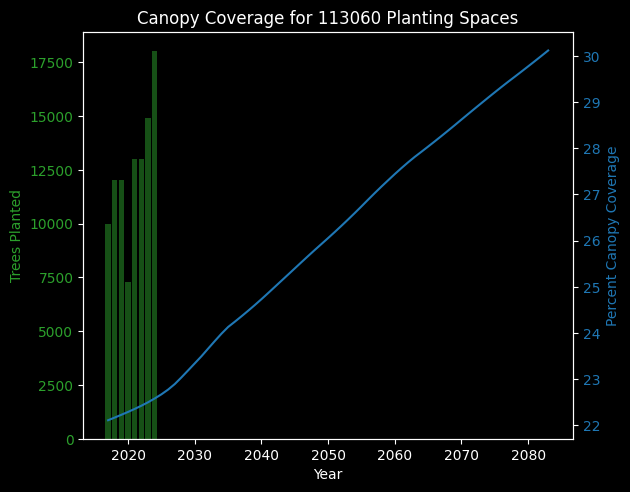

The canopy reaches 30% in the year: 2083


In [14]:
# Model Run with 113060 available planting spots
max_trees = 113060

year_achieved = years_to_goal(max_trees)
print(f"The canopy reaches 30% in the year: {year_achieved}")


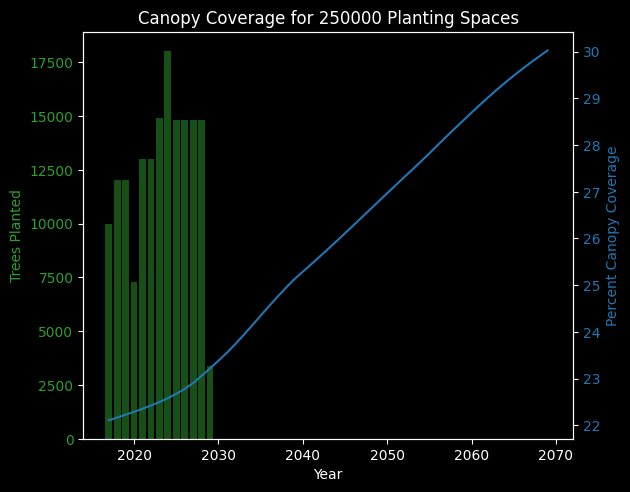

The canopy reaches 30% in the year: 2069


In [188]:
# Model Run with 250,000 available planting spots
max_trees = 250000

year_achieved = years_to_goal(max_trees)
print(f"The canopy reaches 30% in the year: {year_achieved}")


## Conclusion

The goal of this project was to model how New York City could achieve a 30% tree canopy coverage by 2035. Through detailed simulations, the model determined that planting 318,812 trees annually is necessary to achieve this goal. But these results conflict with phsyical constraints. There are only current estimated 113,060 available planting spaces still available in the city. If these spots are all planted with saplings by 2035, the target canopy coverage won't be met until 2083. Increasing planting spaces to 250,000 could achieve the goal by 2069. 

The simulation factored in species-specific growth rates and tree characteristics like maximum age and canopy diameter. Validation against historical data and sensitivity analyses were conducted, but the model has limitations. For instance, it assumes uniform growth rates across tree species and overlooks tree mortality rates from diseases, pests, or extreme weather. It also assumes fixed planting spaces, disregarding potential new opportunities from urban development or policy changes.

Future research could refine the model by incorporating dynamic growth rates, mortality factors, and exploring new planting spaces like green roofs and reclaimed urban areas. Understanding climate change impacts on urban tree growth and evaluating broader socioeconomic benefits of increased canopy coverage will be crucial for effective urban greening strategies.


### References

Department of Parks and Recreation (DPR). n.d. “Forestry Planting Spaces.” https://opendata.cityofnewyork.us/.
NYC Parks. 2020. “Tracking the Tree Canopy.” https://storymaps.arcgis.com/stories/5353de3dea91420faaa7faff0b32206b.
———. 2021. “Tree Procurement.” https://static.nycgovparks.org/images/pagefiles/52/Tree_Procurement.pdf.
———. 2023. “NYC Parks Announces Highest Tree Planting Total in Six Years.” Press Release. https://www.nycgovparks.org/news/press-releases?id=22083.
Treglia, M. L., M. Acosta-Morel, D. Crabtree, K. Galbo, T. Lin-Moges, A. Van Slooten, and E. N. Maxwell. 2021. “The State of the Urban Forest in New York City.” The Nature Conservancy. https://doi.org/10.5281/zenodo.5532876.